<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Astro_Stat_Project2/blob/development/Project2_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AST/STAT 5731 Project 2
## Research Synopsis
**Group 3**   
Daniel Warshofsky  
Hari Veeramallu  
Jacynda Alatoma  
Nicholas Kruegler

### 0. Research Question

What is the value of Hubble's constant as found from a linear regression of the redshifts and distances of Type Ia supernovae within a redshift of 0.1?

### 1. Preamble  


Hubble's law is a relationship that describes the expansion of the universe by connecting the speed at which galaxies move away from each other with the distance between the two objects. For small distances, Hubble's law is a linear relationship between the velocity of the object and the distance:

$v=H_0 d$ or $z=\frac{H_0}{c}d$

where $z$ is the redshift, $v=cz$ is the velocity of the object, $H_0$ is Hubble's constant. The faster a body moves away from the observer, the more redshifted the light emitted from that body is. Thus, further bodies will move away faster and have a higher redshift. The linear scaling of this redshift increase is determined by Hubble's constant.

Type Ia supernovae provide one possible route for investigating Hubble's law. These objects are standardizable candles, meaning that their distance to the observer can be determined with few parameters. From the data set used for this project, the distance will be determined from their peak magnitude, color and shape of the light curve. The redshift for these supernovae is also provided, allowing for the the determination of Hubble's constant through a linear regression.

The data set being used is limited to Type Ia supernovae up to a redshift of $1.3$. The data provides the redshift relative to the universe rest frame (the CMB rest frame) and the peak magnitude of the supernova. To avoid having to account for cosmological effects in the relationship between redshift and distance, only supernovae within a redshift of 0.1 will be used. As provided in the reference paper, the distance can be calculated for these supernovae from a consideration of the peak magnitude, a time-stretching parameters and the color of the supernova.

A complicating factor for this data set is in the residuals from a linear fit. The errors for the measurements of the peak magnitude increases for larger magnitudes, which means that the intrinsic spread doesn't follow a simple normal distribution. One initially considered correction method for this is a Box-Cox Transformation, but this presented the problem that Hubble's constant could not then be found from the regression. Instead, we went forward with the analysis assuming normally distributed errors as a trade-off to allow us to derive Hubble's constant from the analysis.

We are using a Bayesian Analysis on the dataset as opposed to a frequentist method since it allows for use to incorporate and use prior knowledge on the data, which leads to a better fit of the model overall and allows us to draw better conclusions from the data. The goals of the analysis are ultimately to estimate Hubble's constant from the data using normal linear regression.  

Literature Reference: [Improved cosmological constraints from a joint analysis of the SDSS-II and SNLS supernova samples](https://www.aanda.org/articles/aa/pdf/2014/08/aa23413-14.pdf)

### 2. Software and Installation

We recommend using a `conda` environment to install the requirements and run the notebook.  

1. Install Conda
Conda can be installed from this page: https://conda.io/projects/conda/en/latest/user-guide/install/index.html.  

2. Create a conda environment
```
conda create --name ast5731_group3_project2 --file requirements.txt
```
You can change the name of the environment from `ast5731_group3_project1` to the one you want.

3. Install Jupyter notebook from this page: https://jupyter.org/install  

4. The notebook can be run using by starting the jupyter notebook server

```
# to start the server
jupyter notebook
```

Navigate to the file and run the `Group3_Project2_DataSummary.ipynb`

### 3. Explanation of the Model and Data

#### 3.1 **Processing Data and Explanation of Variables**

Data for the analysis can be downloaded from [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/A%2bA/568/A22/tablef3) or [GoogleDrive](https://drive.google.com/file/d/1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0/view)

In [ ]:
# load data for this instance

## for google colab
!gdown 1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0

## for local environment
# !gdown https://drive.google.com/uc?id=1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0

Downloading...
From: https://drive.google.com/uc?id=1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0
To: /content/snaeT1.tsv
100% 47.4k/47.4k [00:00<00:00, 88.1MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az

In [ ]:
## setting the theme for the grid
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [ ]:
# NOTE: change the data path to the download path mentioned in the cell above
# This is typically your downloads folder

df = pd.read_csv('/content/snaeT1.tsv',sep='\t')

# for local computation
# df = pd.read_csv('~/Desktop/supernovae_redshift.csv')

In [ ]:
df.describe()

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.323870,0.324449,20.904961,0.115899,0.036589,0.311096,-0.023878,0.038897,9.795342
std,0.276893,0.276748,2.655139,0.018767,0.988554,0.211399,0.084118,0.015694,1.395068
min,0.010000,0.009400,14.148000,0.085000,-2.863000,0.018000,-0.250000,0.012000,5.000000
25%,0.124000,0.124425,19.735500,0.102000,-0.650250,0.148500,-0.084250,0.026000,9.316750
50%,0.229000,0.230500,21.099000,0.114000,0.165500,0.268000,-0.030500,0.035000,10.193500
75%,0.498000,0.499000,23.043000,0.124000,0.775750,0.420000,0.031000,0.050000,10.710250
max,1.299000,1.300000,26.047000,0.175000,2.337000,1.641000,0.260000,0.107000,11.817000


**Column Description:**.

| Column  | Description                 |
| ------- | --------------------------- |
| zcmb    | CMB Frame Redshift          |
| zhel    | Heliocentric Redshift       |
| mb      | B band peak magnitude (in mB)|
| e_mb    | Error in mb                 |
| x1      | SALT2 shape (stretch) parameter |
| e_x1    | Error in x1                 |
| c       | SALT2 color parameter       |
| e_c     | Error in c                  |
| logMst  | $Log_{10}$ Host Stellar Mass|

Our predictor variable in this research problem is distance, which needs to be calculated by the columns given to us, and the response is velocity, which we will also calculate. Ultimately, we will determine Hubble's constant from the model. Since we want to estimate the relationship between the Distance and the Redshift (CMB), we need to compute the distance from the parameters that we have available to us.

Distance can be computed through Distance Modulii $\mu$, defined as
$$ \mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$$
In this definition, $m_{B}^{*}$ is the observed peak magnitude in rest frame B band and $M_{B}$ is the absolute magnitude of the supernova (adjusted based on host galaxy's properties). It depends on the host galalxy's stellar mass ($M_{stellar}$) as follows  
$$M_{B} = \begin{cases} M_{B}^{1} & \text{if $M_{stellar} < 10^{10} M_{\odot}$} \\
M_{B}^{1} + \Delta_{m} & \text{otherwise}
\end{cases}$$ where $M_{\odot}$ is the mass of the Sun. The parameters $\alpha$ and $\beta$ are nuisance parameters that account for the shape of the light curve ($X_{1}$) and the color of the supernova ($C$) respectively. $\beta$ and $M_{B}$ are found to be dependent on the host galaxy properties.  

According to the literature[[1](https://www.aanda.org/articles/aa/pdf/2014/08/aa23413-14.pdf)], $\mu = 5 log_{10}{(d_{L} /10 \,\mathrm{pc})}$, so the distance modulus can be converted into distance (in parsec) using $ d_{L} = 10^{\mu/5 + 1} $. This distance is the luminosity distance $d_L$, which must be corrected to the proper distance with $d_L=d_P(1+z)$

Since there are errors associated with each measurement, we need to estimate the distance errors as well. The error in this measurement is $$\sigma_{\mu} = \sqrt{\sigma_{m_{b}}^{2} + (\alpha \sigma_{X_{1}})^2 + (\beta \sigma_{C})^2}$$ where $\sigma_{m_{b}}, \sigma_{X_{1}}, \sigma_{C}$ refer to the error terms of $m_{b}, X_{1}$ and $C$ (`e_mb`, `e_x1` and `e_c` from the dataset).  

From the literature the values used are, $\alpha = 0.141, \beta = 3.101, M_{B}^{1} = -19.05$ and $\Delta_{M} = -0.07$ (according to the C11 analysis)

In [ ]:
# defining the nuisance parameters
alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

#picking out data within z=0.1
data = df[df["zcmb"]<0.1].copy()

# MB
data['MB'] = MB1 + (DeltaM * (data['logMst'] > 10))

# mu
data['dist_moduli'] = data['mb'] - (data['MB'] - alpha * data['x1'] + beta * data['c'])

# distance
data['d'] = 10 ** (data['dist_moduli']/5 - 5)/(1+data["zcmb"])  #converting to Mpc and proper distance

# distance modulii (mu) error
data['e_mu'] = np.sqrt(data['e_mb'] ** 2 + (alpha * data['e_x1']) ** 2 + (beta * data['e_c']) ** 2)

# distance error
data['e_d']= (data['e_mu'] * np.log(10) * np.abs(data['d']))/5

In [ ]:
#summary of the z<0.1 data
data.describe()

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst,MB,dist_moduli,d,e_mu,e_d
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.038625,0.038677,16.704684,0.139704,-0.322553,0.134072,0.000250,0.026868,10.247789,-19.103882,35.762311,164.983795,0.165633,12.262058
std,0.023841,0.024271,1.375018,0.015207,1.095961,0.103282,0.081259,0.008219,1.066666,0.029568,1.387712,102.729030,0.021707,7.396870
min,0.010000,0.009400,14.148000,0.110000,-2.863000,0.018000,-0.146000,0.012000,5.000000,-19.120000,33.074674,40.795610,0.117129,3.624371
25%,0.020750,0.020175,15.738000,0.139000,-1.173500,0.069000,-0.055000,0.022000,10.055750,-19.120000,34.756614,87.578353,0.155352,6.763428
50%,0.030000,0.030350,16.645500,0.142000,-0.246500,0.108000,-0.017000,0.025000,10.525500,-19.120000,35.692523,133.493711,0.166288,9.964005
75%,0.055000,0.054650,17.807500,0.148000,0.605500,0.175250,0.057750,0.029000,10.842250,-19.120000,36.930773,230.963838,0.173122,16.943791
max,0.096000,0.097000,19.773000,0.175000,2.022000,0.782000,0.229000,0.058000,11.381000,-19.050000,38.402242,437.956602,0.244960,32.675360


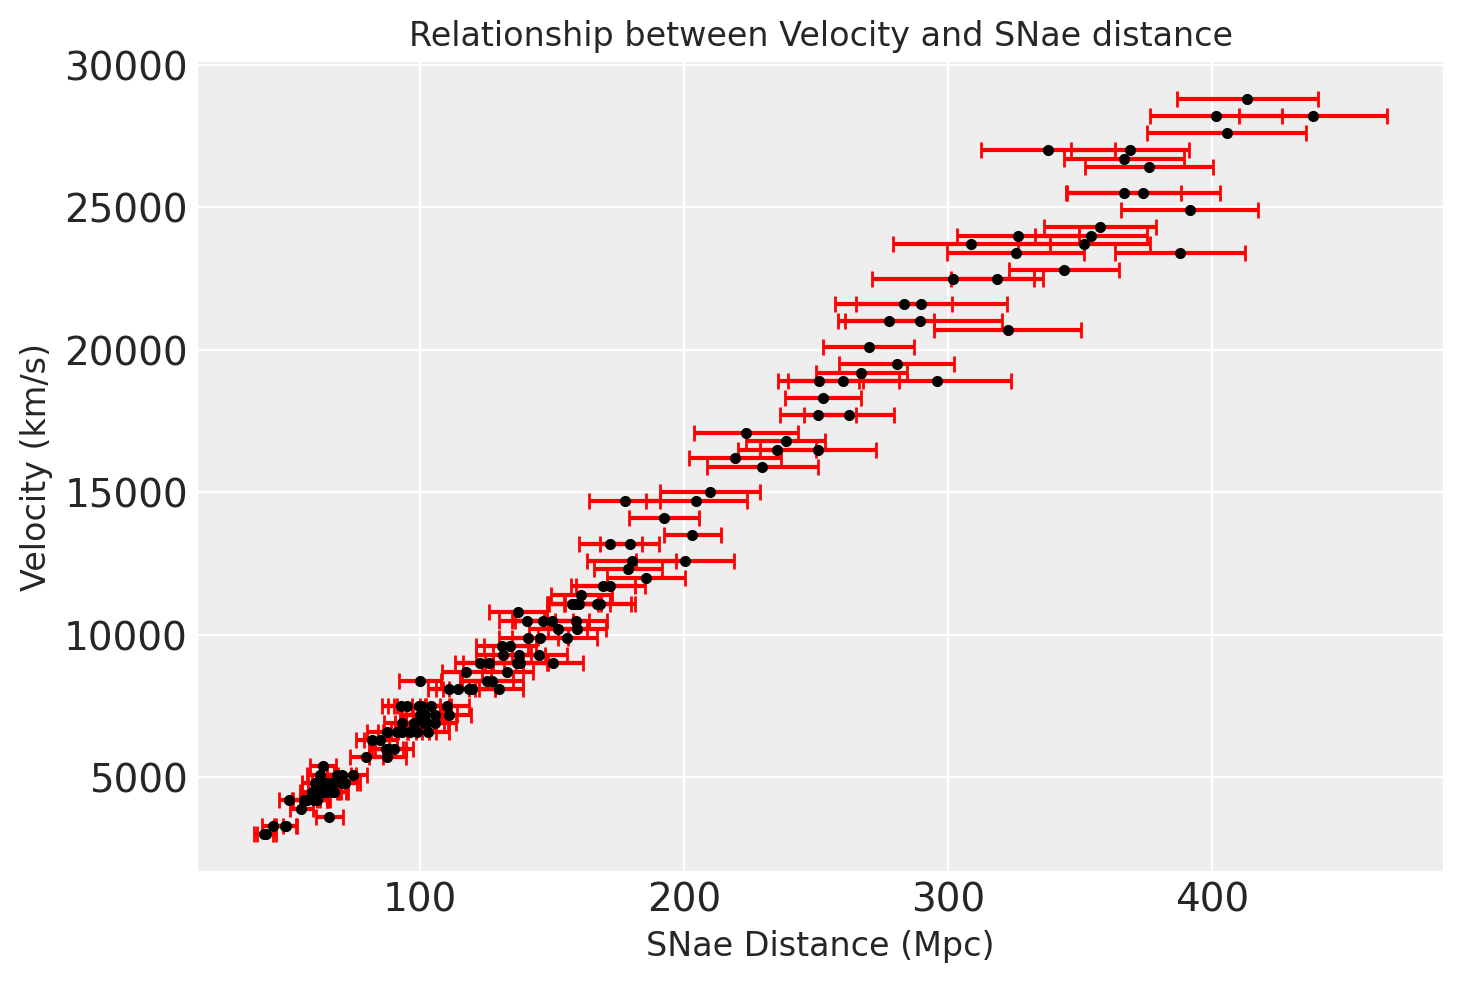

In [ ]:
plt.errorbar( data['d'],data['zcmb']*(3e5),xerr=data['e_d'],fmt="k.",ecolor="r",capsize=3)
plt.ylabel('Velocity (km/s)', size=12)
plt.xlabel('SNae Distance (Mpc)', size=12)
plt.title('Relationship between Velocity and SNae distance', size=12)
plt.show()

We can see from the graph above that the distance and velocity have a clear, positive, and linear relationship as expected by Hubble's Law. More datapoints are found at smaller distances and become more sparse at larger distances. The red bars on the graph are the error measurements per each distance measurement. The error is also found to be larger for larger distances, which could complicate the analysis, but we will move forward assuming Gaussian error.

#### 3.2 **Statistical Model**  

1. $x$, the redshift of the SNae
2. $X=(0,0.1]$, the set of all redshift values less than 0.1
3. Observed distance (in Mpc), $y=[41.2,479.1]$ (i.e. the given data)
4. Sample space, $Y = \mathbb{R}_+^{n}$  
5. The likelihood for our normal regression is $$Y|X,\beta,\tau \sim N(x_i\beta,\tau^{-1})$$
where $x_i\beta$ is the linear regression model $x_i\beta = H_0 d$, the response (velocity) $Y=cz$ is the speed of light $c$ times the redshift $z$, the distance $d$ in Mpc is $d=10^{\mu/5-5}$, and the modulus is $\mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$.

6. The color and stretch parameters can take on any real value, so a normal distribution is justified for them. The apparent magnitude is also allowed to be positive or negative, so a normal is allowed, though only positive values appear in our data set. For simplicity, we also define the Hubble constant as a Gaussian prior. Finally, we use a gamma distribution for the precision of the response variable, since this must be a positive value. Thus, the priors for our model parameters are defined as
$$H_0 \sim N(0,1000)$$
$$m_B \sim N(0,1000)$$
$$X_1 \sim N(0,1000)$$
$$C \sim N(0,1000)$$
$$\tau \sim \mathrm{Gamma}(1,1)$$
which involve standard weakly informative choices for the hyperparameters of the normal and gamma distributions.
Each of these priors (call them $\Psi$), excluding $\tau$ and $H_0$, also have observed values, $\Psi^*$, that are determined from measurement error with the general form
$$\Psi^* \sim N(\Psi,\sigma_{\psi}^2)$$ These $\Psi^*$ distributions are the data that would be directly observed.

In [ ]:
#full model
z = data["zcmb"]
velocity = z*(3e5)
dist_mod = data["dist_moduli"]
dist_mod_err = data["e_mu"]

alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

with pm.Model() as model:
    #Define data
    x=pm.MutableData('x',data['x1'])
    c=pm.MutableData('c',data['c'])
    mb=pm.MutableData('mb',data['mb'])
    MB=pm.MutableData('MB',data['MB'])

    #define H0
    H0 = pm.Normal("H0",mu=0,tau=1/1000)
    p = pm.Gamma('precision', alpha=1, beta=1)

    X = pm.Normal("X",mu=0,tau=1/1000)
    X_obs = pm.Normal("X_obs",mu=X,tau=1/data['e_x1']**2,observed=x,shape=len(data['x1']))

    C = pm.Normal("C",mu=0,tau=1/1000)
    C_obs = pm.Normal("C_obs",mu=C,tau=1/data['e_c']**2,observed=c,shape=len(data['c']))

    m = pm.Normal("m",mu=0,tau=1/1000)
    m_obs = pm.Normal('m_obs',mu=m,tau=1/data['e_mb']**2,observed=mb,shape=len(data['mb']))

    #define modulus model with measurement error
    distance_mod = pm.Deterministic("distance_mod", m - (MB - alpha * X + beta * C))
    distance = pm.Deterministic("distance",10**(distance_mod/5-5)/(1+z))   # -5 to account for conversion from Pc to MPc

    #define response
    Y = pm.Normal("velocity",mu=H0*distance,tau=p,observed=velocity)

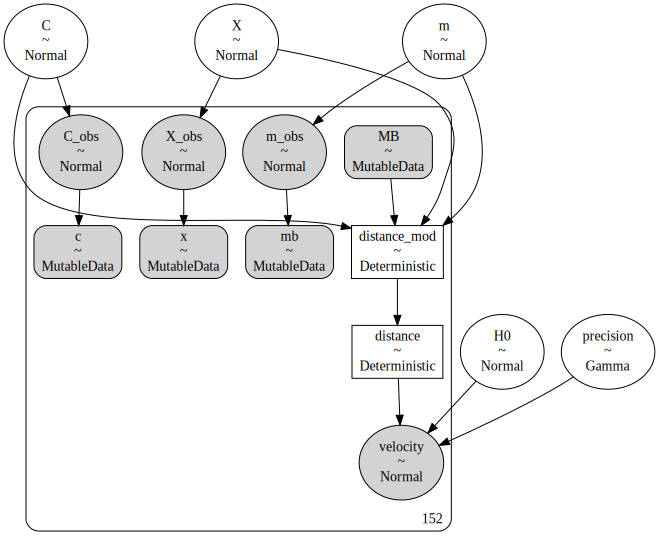

In [ ]:
pm.model_to_graphviz(model)

#### 3.3 Prior Predictive Check

We perform a prior predictive check to ensure that our choices for the priors in model can accurately recreate our available data and ensure our model behaves properly. We define a new model here that is similar to our above model to ensure that the two did not conflict. The point of the prior predictive check is to sample from multiple variations of the priors without looking at the observed data and seeing if it creates similar shapes to what we want to achieve when fitting our model later on.

In [ ]:
import xarray as xr

# standardizing variables just for the sake of axis scales
# def standardize(series):
#     """Standardize a pandas series"""
#     return (series - series.mean()) / series.std()

z = data["zcmb"]
velocity = z*(3e5)
dist_mod = data["dist_moduli"]
dist_mod_err = data["e_mu"]

alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

with pm.Model() as prior:
    #Define data
    mb=pm.MutableData('mb',data['mb'])
    MB=pm.MutableData('MB',data['MB'])

    #define priors
    H0 = pm.Normal("H0",mu=0,tau=1/1000)
    p= pm.Gamma('precision', alpha=1, beta=1)
    X = pm.Normal("X",mu=0,tau=1/1000)
    C = pm.Normal("C",mu=0,tau=1/1000)
    m = pm.Normal("m",mu=0,tau=1/1000)

    #define modulus model with measurement error
    distance_mod = pm.Deterministic("distance_mod", m - (MB - alpha * X + beta * C))
    distance = pm.Deterministic("distance",(10**(distance_mod/5-5))/(1+z))   #+7 to account for conversion from Pc to MPc

    # This is calculating our Y (likelihood)
    Y = pm.Normal("velocity",mu=H0*distance,tau=p,observed=velocity)

    # adding this for prior predictive checks
    idata = pm.sample_prior_predictive(samples=50, random_seed=5731)


# predicting on the prior data (this is where it's going wrong probably)

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior

# Dimension errors so just getting first sample
y = prior["distance"] * x


# # Convert x and y to numpy arrays for plotting
x_values = x.values
y_values = y.values

# fig, ax = plt.subplots()

# # Plotting the predictive check
# ax.plot(x_values, y_values, c="k", alpha=0.4)

# ax.set_xlabel("Predictor")
# ax.set_ylabel("Mean Outcome")
# plt.show()

From the prior predictive check, we find that ...

#Make sure to finish writing this section

### 4. Details of the Computations

The code was ran in Python and specifically implemented in Jupyter Notebook. We used PyMC to code and run our linear model. MCMC was used in the model and below are the graphed trace of the model and each variable in which MCMC sampled. The graphs in order are H0, X, C, m, precision, distance_mod (distance modulus), and distance.

In [ ]:
#find minimum sample size
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

#one parameter of beta so we have 3 degrees of freedom
N_sample = minESS(3).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8123


In [ ]:
with model:
  trace = pm.sample(9000)

array([[<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'X'}>, <Axes: title={'center': 'X'}>],
       [<Axes: title={'center': 'C'}>, <Axes: title={'center': 'C'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>],
       [<Axes: title={'center': 'distance_mod'}>,
        <Axes: title={'center': 'distance_mod'}>],
       [<Axes: title={'center': 'distance'}>,
        <Axes: title={'center': 'distance'}>]], dtype=object)

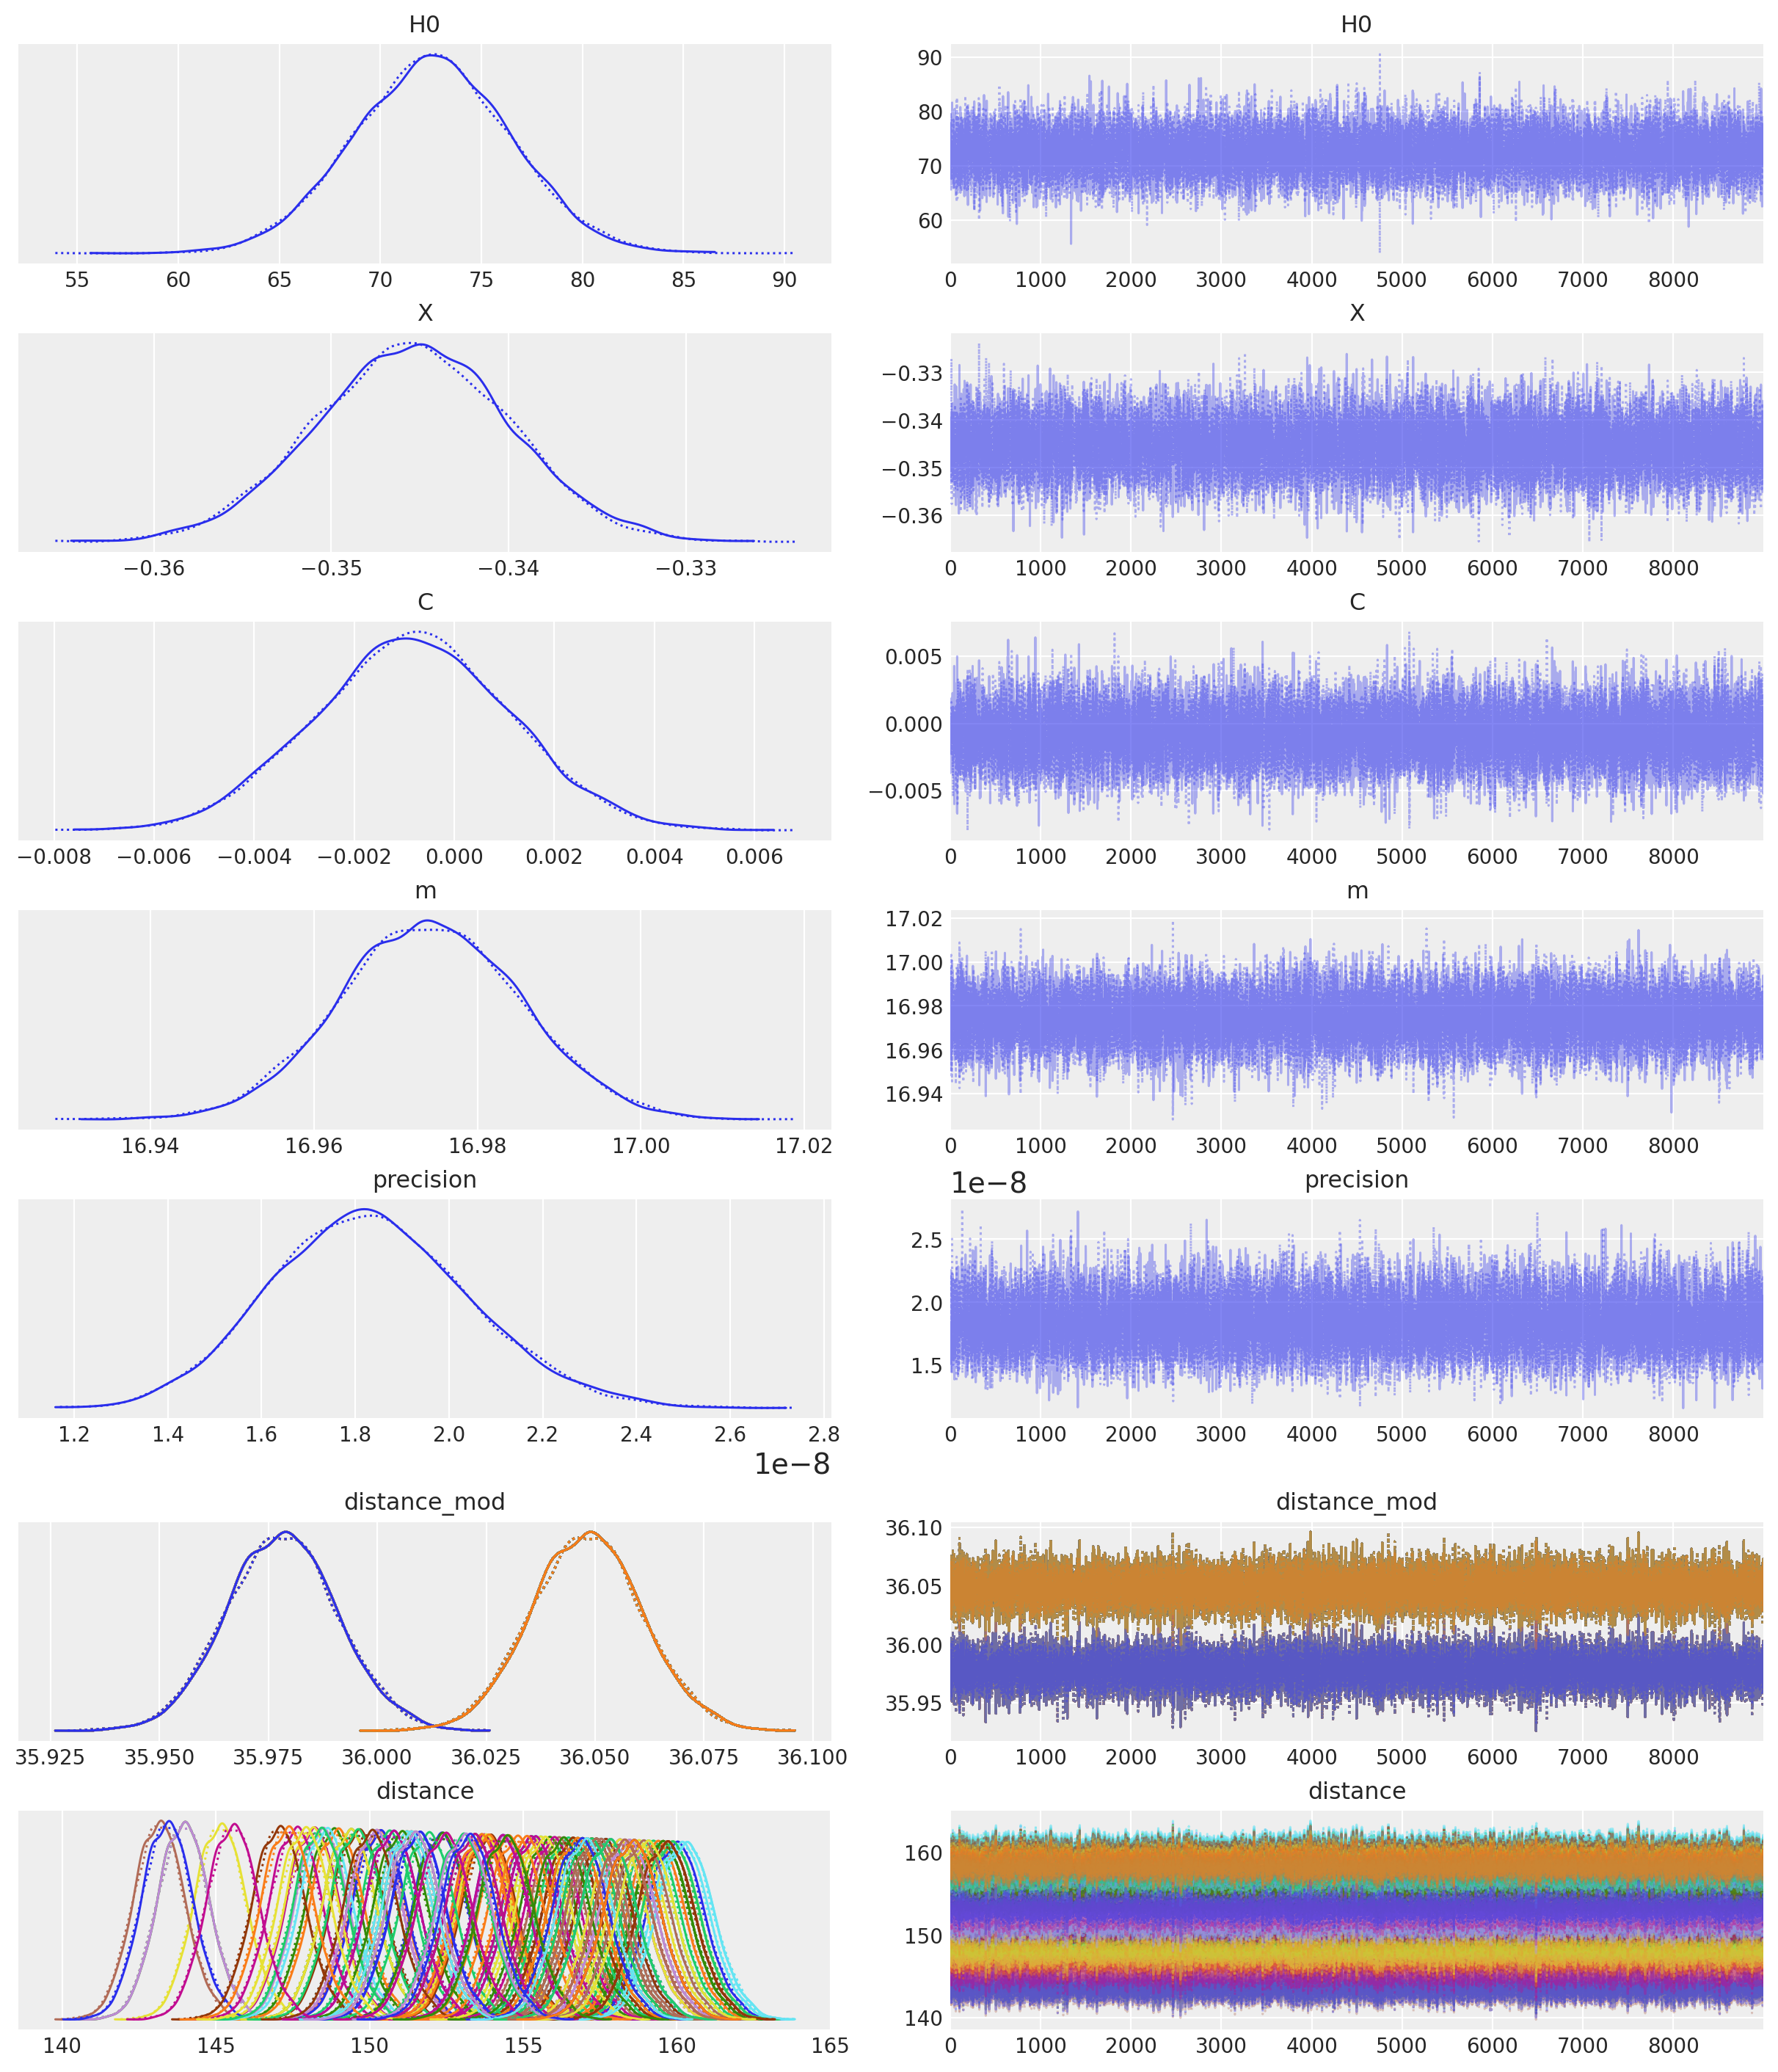

In [ ]:
az.plot_trace(trace)

### 5. Posterior Distribution

#### 5.1 Posterior Predictive Check

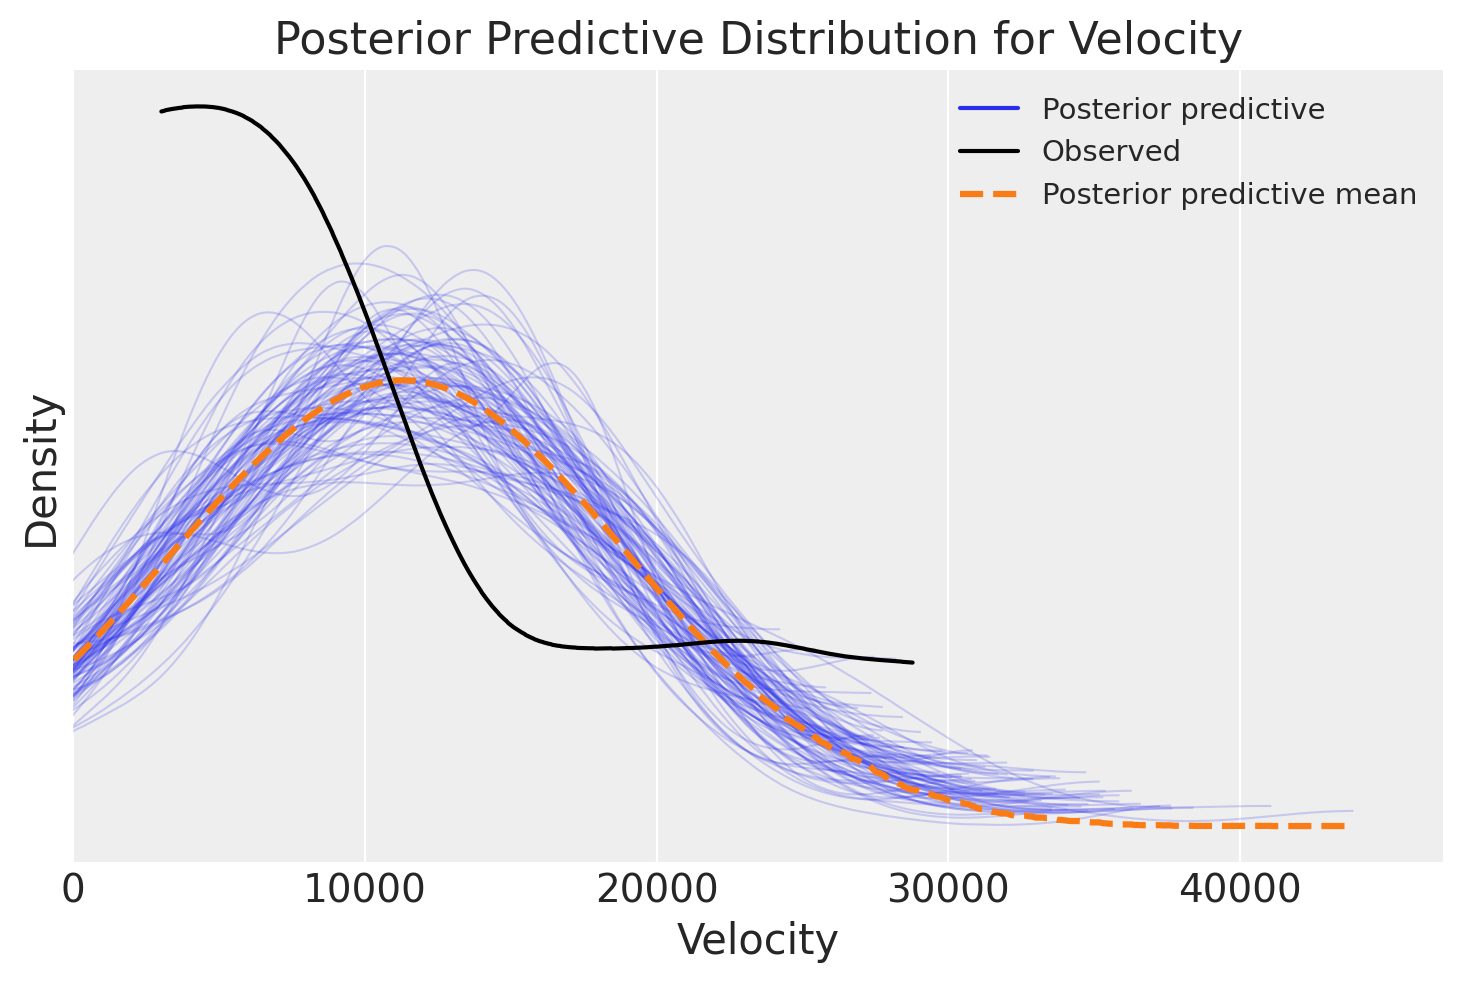

In [ ]:
# Posterior Predictive
with model:
    # idata.extend(pm.sample(1000, tune=2000, random_seed=5731))
    post = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=5731)

az.plot_ppc(post, var_names = ['velocity'], num_pp_samples=100);
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title('Posterior Predictive Distribution for Velocity')
plt.xlim(0, None)
plt.show()

From the posterior predictive check, we find that our model didn't accurately model the desired behavior for the velocity values we'd expect to measure in future measurements. However, we are unable to pin down what the cause of this error was.

#### 5.2 Posterior of H0

For the analysis, we are using 95% HDI intervals to estimate the posteriors of our variables. Below is the code for the posterior of our Hubble's constant. It is shows through the model that the mean of the posterior distribution is 72.54 km/s/MPc and the 95% HDI interval is 64.74 km/s/MPc to 80.09 km/s/MPc.

In [ ]:
az.summary(trace,var_names=["H0"],round_to=2,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H0,72.535,3.913,64.737,80.093,0.024,0.017,25775.034,14927.252,1.0


<Axes: title={'center': 'H0'}>

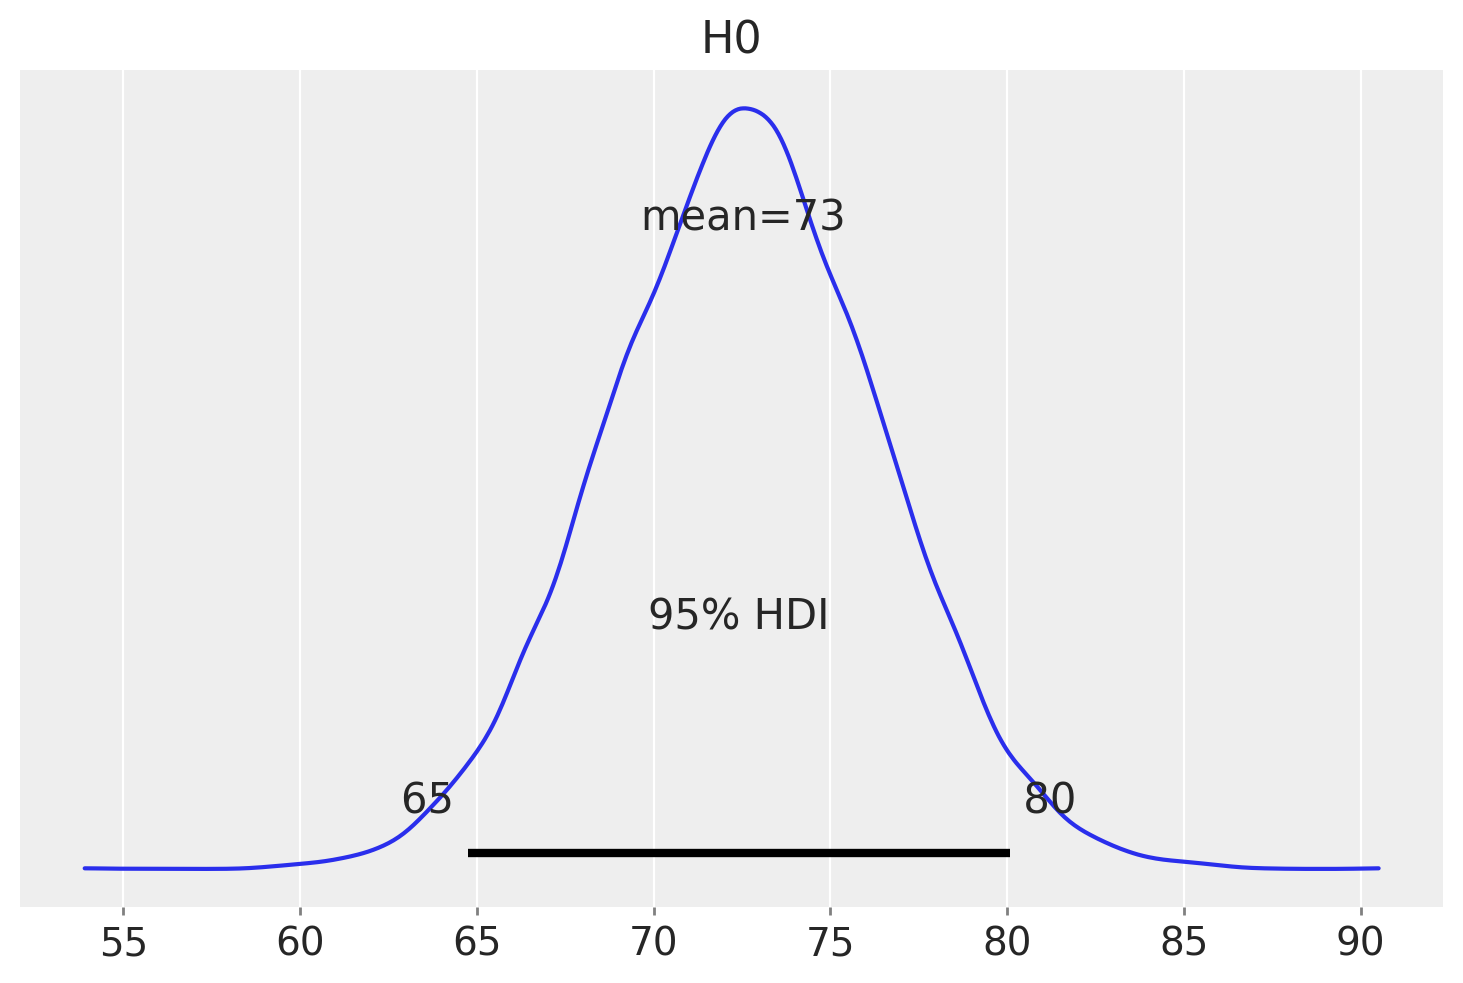

In [ ]:
az.plot_posterior(trace,var_names=["H0"],hdi_prob=0.95)

In this next plot below we sampled from the posterior for Hubble's constant, and then fit a line according to those values to our plot and overlayed the observed data from it. The line of the posterior also includes the HDI 95% interval shadded around it. We can see that it fits very well to the observed data, with the points at the higher values of distance not fitting as well as the lower values of distance.

In [ ]:
n=1000
samp = trace.posterior.sel(chain=np.random.choice(range(0,2),size=n),
                                  draw=np.random.choice(range(0,9000),size=n,replace=False))
samp=np.array([samp['H0'][0]])

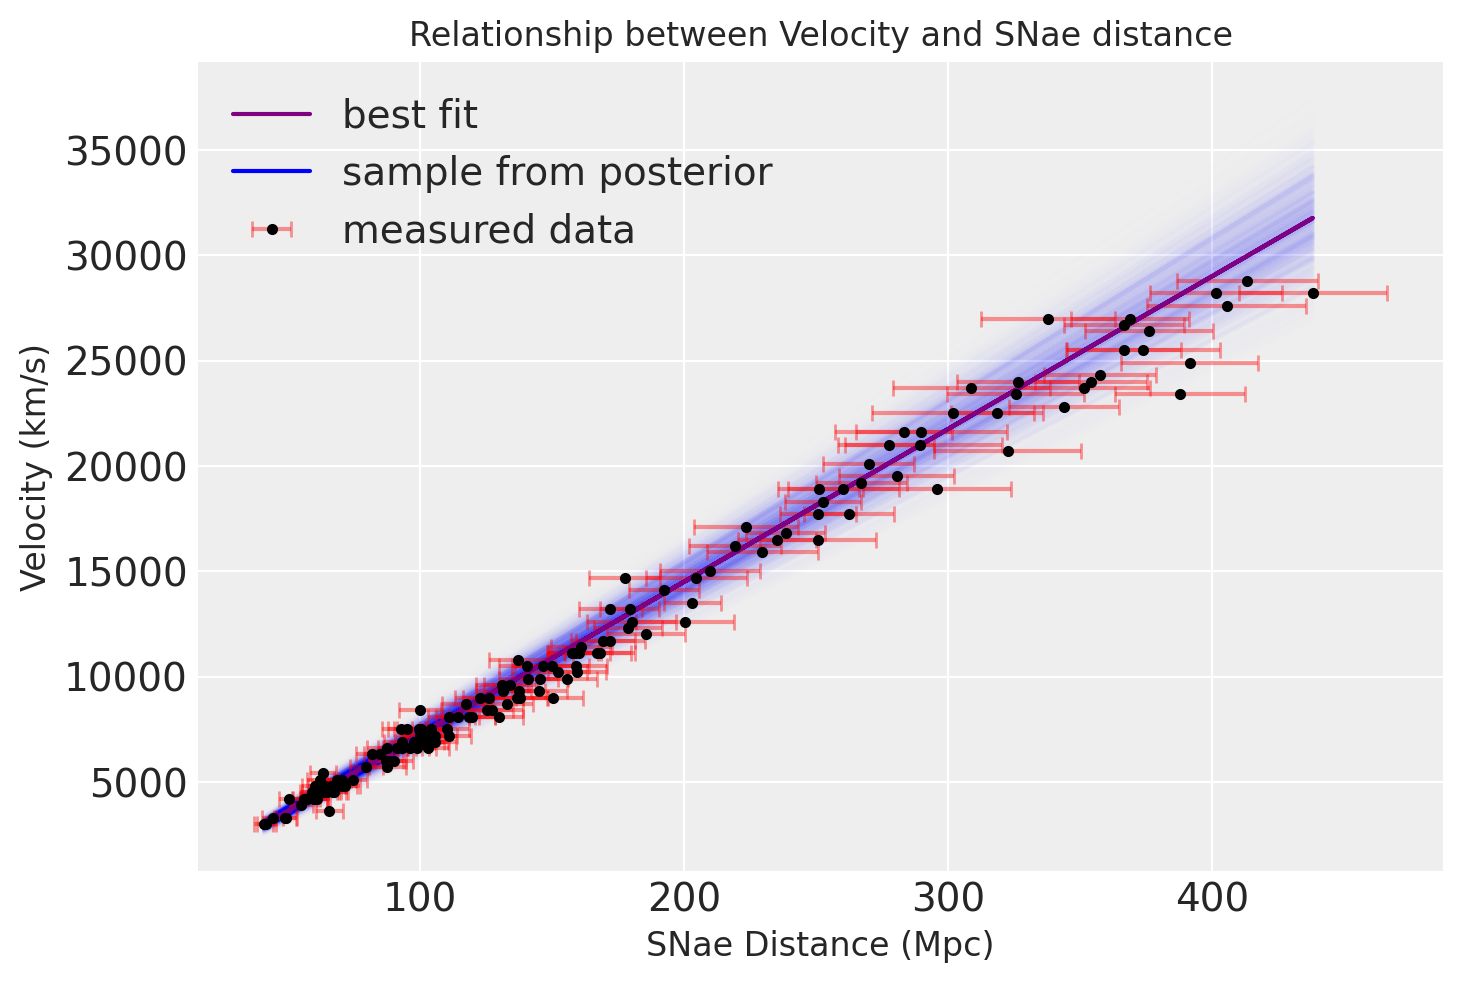

In [ ]:
fig,ax=plt.subplots()

ax.errorbar(data['d'],3e5*data['zcmb'],xerr=data['e_d'],fmt="k.",ecolor=[1,0,0,0.4],capsize=3,zorder=2,label="measured data")
ax.set_ylabel('Velocity (km/s)', size=12)
ax.set_xlabel('SNae Distance (Mpc)', size=12)
ax.set_title('Relationship between Velocity and SNae distance', size=12)

H0_mean = az.summary(trace,var_names=["H0"],round_to=3,hdi_prob=0.95)["mean"].values[0]
ax.plot(data["d"],H0_mean*data["d"],color="purple",label="best fit")

#only present to get axis label there (will be hidden under other parts)
ax.plot(data["d"],H0_mean*data["d"],color="blue",label="sample from posterior",zorder=0)

for H0 in samp.T:
    ax.plot(data["d"],H0*data["d"],alpha=0.005,color='blue',zorder=1)

plt.legend()

### 6. Reporting Conclusions

From the posterior distributions, we used MCMC simulations to determine a Hubble’s constant of 72.5 km/s/Mpc. This aligns closely to the “late-universe” value of 73 km/s/Mpc determined from distance ladder techniques. However, these measurements include more than just supernovae measurements so are expected to be more accurate.


### 7. Reproducibility

The CSV file of the data used can be found at [Google Drive](https://drive.google.com/file/d/1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0/view). All random seed generators used in the calculation had a seed set to 5731. Can be run using any Python environment that also supports PyMC. The required packages to install to be able to run the code are found in section 2.1 and 3.